In [15]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import py4a.api.accessor as accessor
from typing import Tuple
from collections import defaultdict

In [2]:
os.makedirs("output/figs/", exist_ok=True)

In [3]:
def get_api_usage_data(scope="latest") -> Tuple[pd.DataFrame, pd.DataFrame]:
    client_stat = []
    api_stat = defaultdict(lambda: {"clients": 0, "files": 0, "calls": 0})
    for fname in os.listdir(f"output/static/api-usage-{scope}"):
        with open(f"output/static/api-usage-{scope}/" + fname, "r") as f:
            stat = json.load(f)
        client_stat.append({
            "u_pkg": stat["u_pkg"],
            "u_ver": stat["u_ver"],
            "c_pkg": stat["c_pkg"],
            "c_ver": stat["c_ver"],
            "apis": len(stat["api_stats"]),
            "files": sum(x["files"] for x in stat["api_stats"].values()),
            "calls": sum(x["calls"] for x in stat["api_stats"].values()),
        })
        for api_name, s in stat["api_stats"].items():
            key = (stat["u_pkg"], stat["u_ver"], api_name)
            api_stat[key]["clients"] += 1
            api_stat[key]["files"] += s["files"]
            api_stat[key]["calls"] += s["calls"]
    api_stat_df = []
    for (u_pkg, u_ver, api_name), stat in api_stat.items():
        api_stat_df.append({
            "u_pkg": u_pkg, 
            "u_ver": u_ver, 
            "api": api_name, 
            "clients": stat["clients"], 
            "files": stat["files"], 
            "calls": stat["calls"]
        })
    client_stat_df = pd.DataFrame(client_stat).sort_values(by=["u_pkg", "apis"], ascending=[True, False])
    api_stat_df = pd.DataFrame(api_stat_df).sort_values(by=["u_pkg", "clients"], ascending=[True, False])
    return client_stat_df, api_stat_df
                                                          
client_stat, api_stat = get_api_usage_data()
client_stat.to_csv("output/api_usage_client.csv", index=False)
api_stat.to_csv("output/api_usage.csv", index=False)

In [4]:
client_stat_all, api_stat_all = get_api_usage_data(scope="all")
print(len(set(zip(client_stat_all.u_pkg, client_stat_all.u_ver))), " packages and versions")
print(len(client_stat_all), " clients")
print(sum(client_stat_all.files), " files")
print(sum(client_stat_all.calls), " calls")

377  packages and versions
78854  clients
64308794  files
132688761  calls


In [5]:
client_stat_all.describe()

,apis,files,calls
count,78854.000000,78854.000000,7.885400e+04
mean,26.753659,815.542572,1.682714e+03
std,41.360067,9797.490449,1.953071e+04
min,0.000000,0.000000,0.000000e+00
25%,4.000000,10.000000,1.200000e+01
50%,12.000000,47.000000,6.900000e+01
75%,32.000000,165.000000,2.660000e+02
max,342.000000,624325.000000,1.299996e+06


In [6]:
client_stat.head(5)

,u_pkg,u_ver,c_pkg,c_ver,apis,files,calls
1278,django,4.0,djangorestframework,3.11.2,189,653,991
1329,django,4.0,djangorestframework,3.13.1,188,677,1018
1197,django,4.0,edx-enterprise,3.36.9,164,3093,5284
1163,django,4.0,django-jinja,2.4.1,131,216,251
1186,django,4.0,django-jinja,2.10.0,121,191,211


In [7]:
api_stat.head(5)

,u_pkg,u_ver,api,clients,files,calls
2813,django,4.0,django.conf.settings,153,1578,2385
2812,django,4.0,django.db.models,99,753,755
2851,django,4.0,django.db.models.Model,89,194,404
2820,django,4.0,django.db.models.CharField,87,1474,3569
2874,django,4.0,django.apps.AppConfig,81,151,151


In [18]:
pkgs = [('pandas', '1.3.5'), ('scikit-learn', '1.0.2'), ('django', '4.0'),  ('flask', '2.0.2'), ('tensorflow', '2.7.0'), ('keras', '2.7.0')]
print(pkgs)
all_apis, all_used_apis = 0, 0
for pkg, ver in pkgs:
    apis = accessor.get_apis(pkg, ver, dynamic=False)
    num_apis = sum(len(api.keys()) for api in apis.values())
    num_clients = len(client_stat[client_stat.u_pkg == pkg])
    num_used_apis = len(api_stat[api_stat.u_pkg == pkg])
    all_apis += num_apis
    all_used_apis += num_used_apis
    print(f"{pkg:12}: {num_apis:5} APIs, {num_used_apis:4} APIs "
          f"({num_used_apis / num_apis * 100:4.2f}%) used in {num_clients:3} clients")
print(f"{all_apis} APIs in total in which {all_used_apis} APIs ({all_used_apis / all_apis * 100:.2f}%) are used")

[('pandas', '1.3.5'), ('scikit-learn', '1.0.2'), ('django', '4.0'), ('flask', '2.0.2'), ('tensorflow', '2.7.0'), ('keras', '2.7.0')]
pandas      : 25870 APIs,  733 APIs (2.83%) used in 702 clients
scikit-learn: 14563 APIs,  820 APIs (5.63%) used in 249 clients
django      : 11209 APIs, 1029 APIs (9.18%) used in 204 clients
flask       :   582 APIs,   61 APIs (10.48%) used in  85 clients
tensorflow  : 66314 APIs, 1530 APIs (2.31%) used in 173 clients
keras       : 10304 APIs,  170 APIs (1.65%) used in  34 clients
128842 APIs in total in which 4343 APIs (3.37%) are used


In [19]:
for i, (pkg, ver) in enumerate(pkgs):
    print(f"{pkg:12}: {'Used Clients':12} {'Most Used APIs by Clients':25}")
    data = api_stat[api_stat.u_pkg == pkg].sort_values(by="clients", ascending=False).head(10)
    for i in range(0, 10):
        print(f"{i + 1:12}: {data.clients.iloc[i]:12} {data.api.iloc[i]:25}")

pandas      : Used Clients Most Used APIs by Clients
           1:          626 pandas                   
           2:          598 pandas.DataFrame         
           3:          365 pandas.Series            
           4:          323 pandas.concat            
           5:          295 pandas.read_csv          
           6:          166 pandas.to_datetime       
           7:          135 pandas.DataFrame.set_index
           8:          133 pandas.Index             
           9:          126 pandas.MultiIndex        
          10:          123 pandas.DataFrame.append  
scikit-learn: Used Clients Most Used APIs by Clients
           1:          116 sklearn.base.BaseEstimator
           2:           76 sklearn.linear_model.LogisticRegression
           3:           74 sklearn.model_selection.train_test_split
           4:           69 sklearn.base.TransformerMixin
           5:           67 sklearn.linear_model.LinearRegression
           6:           66 sklearn.preprocessing.Lab

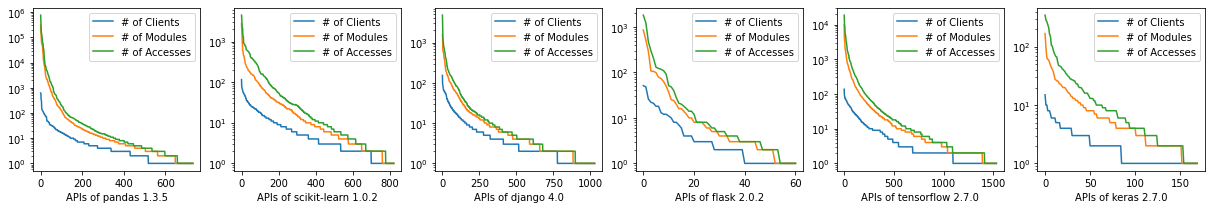

In [20]:
fig, axes = plt.subplots(1, len(pkgs), figsize=(21, 3))
for i, (pkg, ver) in enumerate(pkgs):
    labels = ["# of Clients", "# of Modules", "# of Accesses"]
    for j, col in enumerate(["clients", "files", "calls"]):
        axes[i].plot(
            sorted(api_stat[api_stat.u_pkg == pkg][col], reverse=True),
            label=labels[j],
        )
    axes[i].set_xlabel(f"APIs of {pkg} {ver}")
    axes[i].set_yscale("log")
    axes[i].legend()
fig.savefig("output/figs/api_usage.pdf", bbox_inches="tight")

In [17]:
client_stat.describe()

,apis,files,calls
count,1447.000000,1447.000000,1447.000000
mean,24.105045,1027.107118,2234.493435
std,39.476975,13432.203531,27620.628088
min,0.000000,0.000000,0.000000
25%,3.000000,8.000000,10.000000
50%,9.000000,44.000000,67.000000
75%,26.000000,200.500000,328.500000
max,342.000000,419284.000000,844286.000000


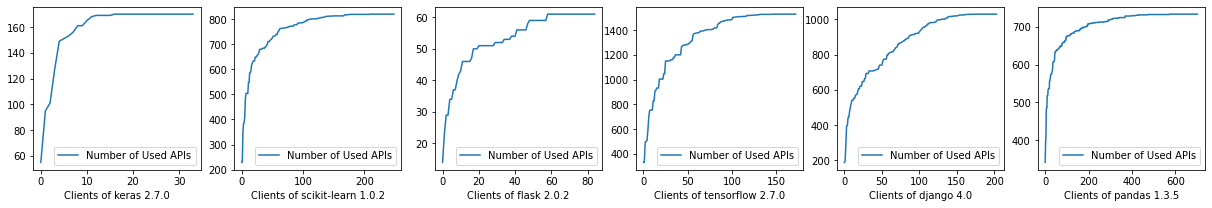

In [12]:
fig, axes = plt.subplots(1, len(pkgs), figsize=(21, 3))
for i, (u_pkg, u_ver) in enumerate(pkgs):
    clients = client_stat[client_stat.u_pkg == u_pkg].sort_values(by="apis", ascending=False)
    apis = set()
    data = []
    for c_pkg, c_ver in zip(clients.c_pkg, clients.c_ver):
        with open(f"output/static/api-usage-latest/{u_pkg},{u_ver},{c_pkg},{c_ver}.json", "r") as f:
            stat = json.load(f)
        apis.update(stat["api_stats"].keys())
        data.append(len(apis))
    axes[i].plot(data, label="Number of Used APIs")
    axes[i].set_xlabel(f"Clients of {u_pkg} {u_ver}")
    axes[i].legend()
fig.savefig("output/figs/api_coverage.png", bbox_inches="tight")

In [13]:
apis = set(accessor.get_apis("pandas", "1.3.5")["pandas"].keys(leaf_only=False))
public_apis = set()
used_apis = set(api_stat[api_stat.u_pkg == "pandas"].api)
for api_name in apis:
    if any(p.startswith("_") and not p.startswith("__") for p in api_name.split(".")):
        continue
    if "pandas.core" in api_name or "pandas.compat" in api_name or "pandas.util" in api_name:
        continue
    public_apis.add(api_name)
print(len(apis), len(public_apis), len(used_apis), len(apis & used_apis), len(public_apis & used_apis))

27293 18361 733 474 254


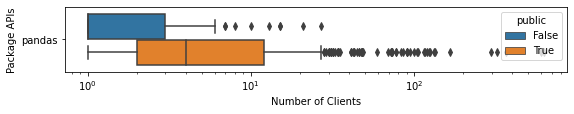

In [14]:
api_stat_pandas = api_stat[api_stat.u_pkg == "pandas"].copy()
api_stat_pandas["public"] = api_stat_pandas.api.map(lambda a: a in public_apis or a not in apis)
api_stat_pandas.to_csv("output/api_stat_pandas.csv", index=False)
fig, ax = plt.subplots(1, 1, figsize=(9, 1.2))
sns.boxplot(y="u_pkg", x="clients", hue="public", data=api_stat_pandas, ax=ax)
ax.set_xscale("log")
ax.set_ylabel("Package APIs")
ax.set_xlabel("Number of Clients")
fig.savefig("output/figs/api_visibility.png", bbox_inches="tight")